In [2]:
from asyncio.windows_events import NULL
import os
from PIL.Image import ID
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import PlottingFunctions as pf
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from time import perf_counter
# %matplotlib widget

In [3]:
def load_object(filename):
    '''
    load an object from a file using the built-in pickle library

    :param filename: Name of the file from which to load data
    '''
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

In [4]:
def XYZoverTime(pos_r, pos_i, pos_p, labels=['real', 'integral', 'prediction'], marker=['b-', 'r--', 'g,']):
    plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(3,1,1)
    plt.plot(pos_r[:,0], marker[0], label=labels[0])
    plt.plot(pos_i[:,0], marker[1], label=labels[1])
    plt.plot(pos_p[:,0], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(3,1,2)
    plt.plot(pos_r[:,1], marker[0], label=labels[0])
    plt.plot(pos_i[:,1], marker[1], label=labels[1])
    plt.plot(pos_p[:,1], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.subplot(3,1,3)
    plt.plot(pos_r[:,2], marker[0], label=labels[0])
    plt.plot(pos_i[:,2], marker[1], label=labels[1])
    plt.plot(pos_p[:,2], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_rolling_timeseries_stats(real, predictions, window_size=200):
    """
    Plot time series for x, y, z coordinates with rolling mean and standard deviation.
    
    Parameters:
    - predictions: NumPy array of shape (n_timesteps, 3)
    - window_size: Size of the rolling window for calculating mean and std dev
    """
    # Create a figure with 3 subplots (one for each coordinate)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    coordinates = ['X', 'Y', 'Z']
    
    for i in range(3):
        # Extract the i-th coordinate
        coord_data = predictions[:, i]
        
        # Calculate rolling mean and standard deviation using pandas-like method
        rolling_mean = np.zeros_like(coord_data)
        rolling_std = np.zeros_like(coord_data)
        
        for j in range(len(coord_data)):
            # Determine the window boundaries
            start = max(0, j - window_size // 2)
            end = min(len(coord_data), j + window_size // 2)
            
            # Calculate local statistics
            window_data = coord_data[start:end]
            rolling_mean[j] = np.mean(window_data)
            rolling_std[j] = np.std(window_data)
        
        # Plot the original time series
        axes[i].plot(np.arange(len(coord_data)), coord_data, 'g,', label='Predictions')
        axes[i].plot(np.arange(len(coord_data)), real[:, i], 'r-', label='Actual')
        
        
        # Plot the rolling mean line
        axes[i].plot(np.arange(len(coord_data)), rolling_mean, color='blue', linestyle='--', 
                     label=f'Mean (window={window_size})')
        
        # Add rolling standard deviation shading
        axes[i].fill_between(np.arange(len(coord_data)), 
                             rolling_mean - rolling_std, 
                             rolling_mean + rolling_std, 
                             color='cyan', alpha=1, 
                             label='±1 std dev')
        
        # Customize the plot
        axes[i].set_ylabel(f'{coordinates[i]} Coordinate')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    axes[-1].set_xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path))
    stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

In [5]:
def plot_frame_figure(gains, positions_array, network_activity, num_bins=50, neuron=42, ID=0, subID=None):
    """
    Plots a heatmap of network activity at different gain levels and overlays the trajectory. 
    The plot is saved in the results folder within the relative directory.

    :param positions_array: list of shape (ntime, ndim) 
    :param num_bins: int 
    :param network_activity: list of shape (ntime, ngain, nneuron)
    :param neuron: int. Default=42
    """
    x_min, y_min = np.min(positions_array, axis=0)
    x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
    for a, alpha in enumerate(gains):

        heatmap_ax = fig.add_subplot(gs[0, a])
        heatmap_ax.set_aspect('equal')

        # Initialize an empty heatmap
        x_bins = np.linspace(x_min, x_max,num_bins)
        y_bins = np.linspace(y_min, y_max,num_bins)
        heatmap = np.zeros((num_bins, num_bins))

        # Iterate over positions and network_activity (Over time)
        for position, activity in zip(positions_array, network_activity):
            x_index = np.digitize(position[0], x_bins) - 1
            y_index = np.digitize(position[1], y_bins) - 1
            heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
            #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID {ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID {ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    #plt.show()
    #plt.close()

def plot_modular_activity(prj_op, pos, ac, gains, ID, projection):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'])
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')


## Load Data and Prepare

In [44]:
name = 'Benchmarking' #'MovementCheck3D'
filename = f'Results\\ID {name}\\Data {name}.pickle'
data = load_object(filename)

online = data['online'] # simulation was online prediction
ID = data['name'] # name of the simulation
boundaries = data['boundaries']
minutes = data['sim time']
dt = data['dt ms'] # in ms
gains = np.array(data['gains']) # list of gains that every network uses
projection = np.array(data['modular projections']) # bool of the dim each module projects
projection_operator = np.array(data['module operators']) # operator used to project 3d data to modules
noise = data['noise']
vel = np.array(data['velocity'])
pos_r = np.array(data['position']) # real position
pos_i = np.array(data['position internal']) # integrator position
pos_p = np.array(data['position prediction']) # predicted position
activity = np.array(data['activity']) # neural network activity 

if online:
    mse_ar = np.array(data['predicted mse']) # mse online
else:
    mse_sc = data['mse'] # scalar mse mean offline
    mse_sh = data['mse_shuffeled'] # scalar mse shuffeled offline
    r2 = data['r2_mean'] # scalar r2 score offline
    r2_sh = data['r2_shuffeled'] # scalar r2 shuffeled offline

In [45]:
print(f'''Simulation was run with {'online' if online else 'offline'} prediction.
Name : {ID}
Minutes simulated : {minutes}
Gains used by 2d modules: {gains}
Amount of modules used : {len(projection)}
Projection of the modules by module and dimension : \n{projection}
Timestep dt of the simulation in ms : {dt}''')

print(f"gains shape: {gains.shape}")
print(f"projection_operator shape: {projection_operator.shape}")
print(f"activity shape: {activity.shape}")
print(f"pos_r shape: {pos_r.shape}")

if online:
    print(f"pos_i shape: {pos_i.shape}")
    print(f"pos_p shape: {pos_p.shape}")
    print(f"mse_ar shape: {mse_ar.shape}")
    print(f'mse mean: {np.mean(mse_ar)}')
else:
    print(f"mse_scalar: {type(mse_sc)}, value: {mse_sc}")
    print(f"mse_shuffeled: {type(mse_sh)}, value: {mse_sh}")
    print(f"r2: {type(r2)}, value: {r2}")
    print(f"r2_shuffeled: {type(r2_sh)}, value: {r2_sh}")

Simulation was run with online prediction.
Name : Benchmarking
Minutes simulated : 10.0
Gains used by 2d modules: [0.2 0.4 0.6 0.8 1. ]
Amount of modules used : 2
Projection of the modules by module and dimension : 
[[ True  True False]
 [False  True  True]]
Timestep dt of the simulation in ms : 32
gains shape: (5,)
projection_operator shape: (2, 2, 3)
activity shape: (18377, 2, 5, 90)
pos_r shape: (18751, 3)
pos_i shape: (18377, 3)
pos_p shape: (18377, 3)
mse_ar shape: (18377, 3)
mse mean: 0.08422774666486285


# Position Data Analysis

Here some code is used to analyse the trajectory took by the drone and how it translates to the noisy internal position integrator and predicted position of the model

In [46]:
start = len(pos_r) - len(pos_i)
t1 = np.arange(0, start)
t2 = np.arange(start, len(pos_r))
pos_iz = np.insert(pos_i[:,2], 0, np.zeros((start)))
azc = np.array(data['acceleration'])
vel_zr = np.gradient(pos_r[:,2], dt/1000, axis=0)
az_r = np.gradient(vel_zr, dt/1000, axis=0)

azc_dif = az_r-azc
vz_dif = (vel_zr - vel[:,2] )*dt/1000
pos_dif = pos_r[:,2] - pos_iz

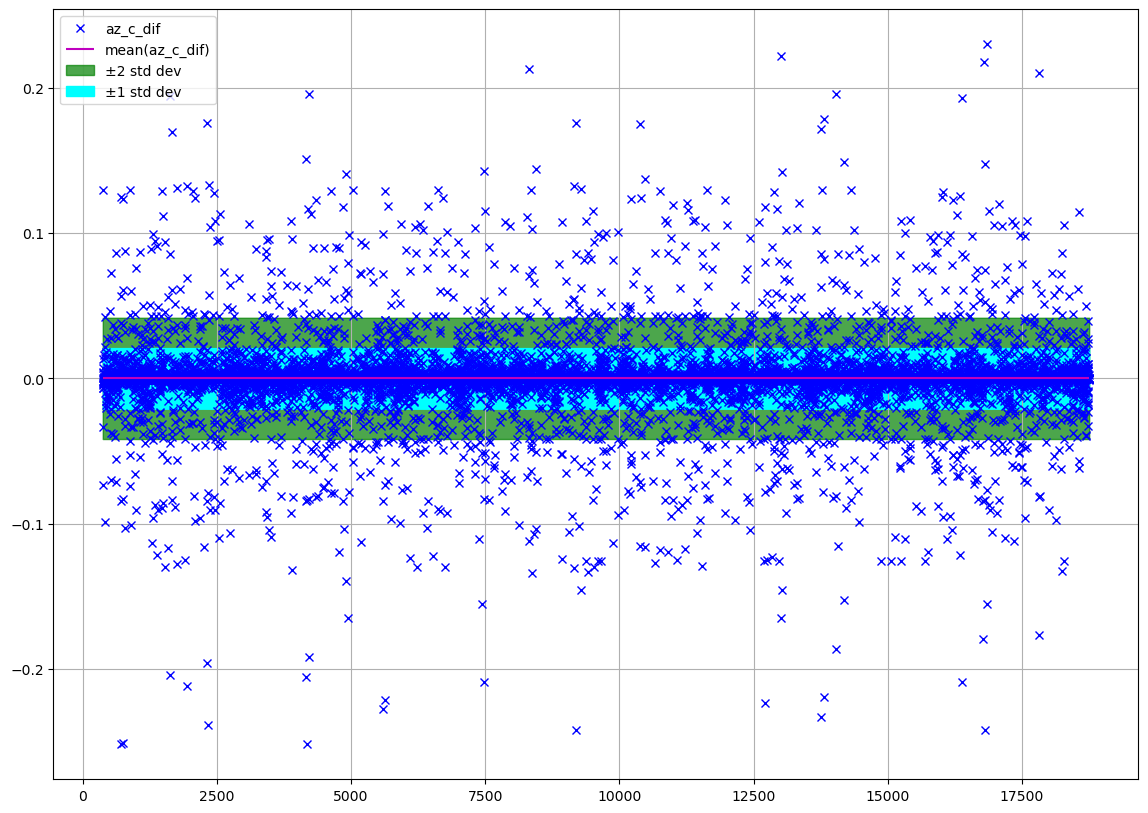

In [47]:
azc_dif_mean = np.mean(azc_dif[start:])
azc_dif_std = np.std(azc_dif[start:])

plt.plot(t2, azc_dif[start:], 'bx', label='az_c_dif')
plt.hlines(azc_dif_mean, t2[0], t2[-1], colors='m', label='mean(az_c_dif)')
plt.fill_between(t2, azc_dif_mean - 2*azc_dif_std, azc_dif_mean + 2*azc_dif_std,  
                             color='green', alpha=0.7, 
                             label='±2 std dev')
plt.fill_between(t2, azc_dif_mean - azc_dif_std, azc_dif_mean + azc_dif_std,  
                             color='cyan', alpha=1, 
                             label='±1 std dev')

plt.grid()
plt.legend()
plt.show()

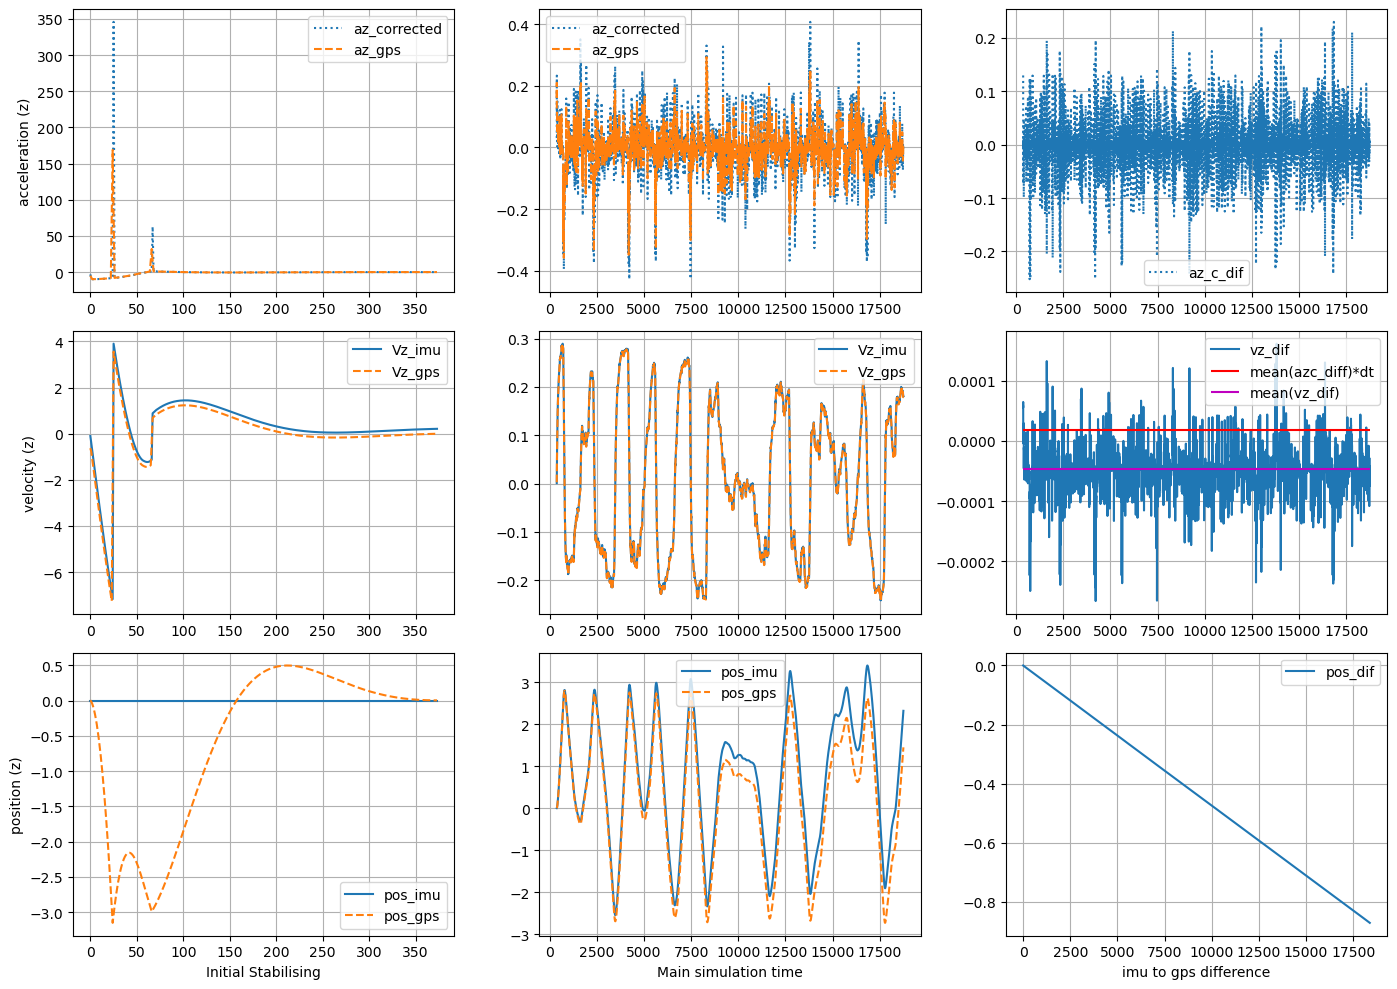

In [48]:
plt.subplot(3,3,1)
plt.ylabel('acceleration (z)')
#plt.plot(t1, az[:start], label='az_imu')
plt.plot(t1, azc[:start], ls=':', label='az_corrected')
plt.plot(t1, az_r[:start], ls='--', label='az_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,2)
#plt.plot(t2, az[start:], label='az_imu')
plt.plot(t2, azc[start:], ls=':', label='az_corrected')
plt.plot(t2, az_r[start:], ls='--', label='az_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,3)
#plt.plot(t2, az_dif[start:], label='az_dif')
plt.plot(t2, azc_dif[start:], ls=':', label='az_c_dif')
#plt.hlines(-9.81, t2[0], t2[-1], colors='r', label='Gravity')
plt.legend()
plt.grid()

plt.subplot(3,3,4)
plt.ylabel('velocity (z)')
plt.plot(t1, vel[:start,2], label='Vz_imu')
plt.plot(t1, vel_zr[:start], ls='--', label='Vz_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,5)
plt.plot(t2, vel[start:,2], label='Vz_imu')
plt.plot(t2, vel_zr[start:], ls='--', label='Vz_gps')
plt.legend()
plt.grid()
plt.subplot(3,3,6)
plt.plot(t2, vz_dif[start:], label='vz_dif')
plt.hlines(np.mean(azc_dif)*dt/1000, t2[0], t2[-1], colors='r', label='mean(azc_diff)*dt')
plt.hlines(np.mean(vz_dif[start:]), t2[0], t2[-1], colors='m', label='mean(vz_dif)')
plt.legend()
plt.grid()

plt.subplot(3,3,7)
plt.ylabel('position (z)')
plt.plot(t1, pos_iz[:start], label='pos_imu')
plt.plot(t1, pos_r[:start,2], ls='--', label='pos_gps')
plt.legend()
plt.grid()
plt.xlabel('Initial Stabilising')

plt.subplot(3,3,8)
plt.plot(t2, pos_iz[start:], label='pos_imu')
plt.plot(t2, pos_r[start:,2], ls='--', label='pos_gps')
plt.legend()
plt.grid()
plt.xlabel('Main simulation time')

plt.subplot(3,3,9)
plt.plot(pos_dif[start:], label='pos_dif')
plt.legend()
plt.grid()
plt.xlabel('imu to gps difference')

plt.tight_layout()
plt.show()

Simulation data
 Using gains:[0.2 0.4 0.6 0.8 1. ]


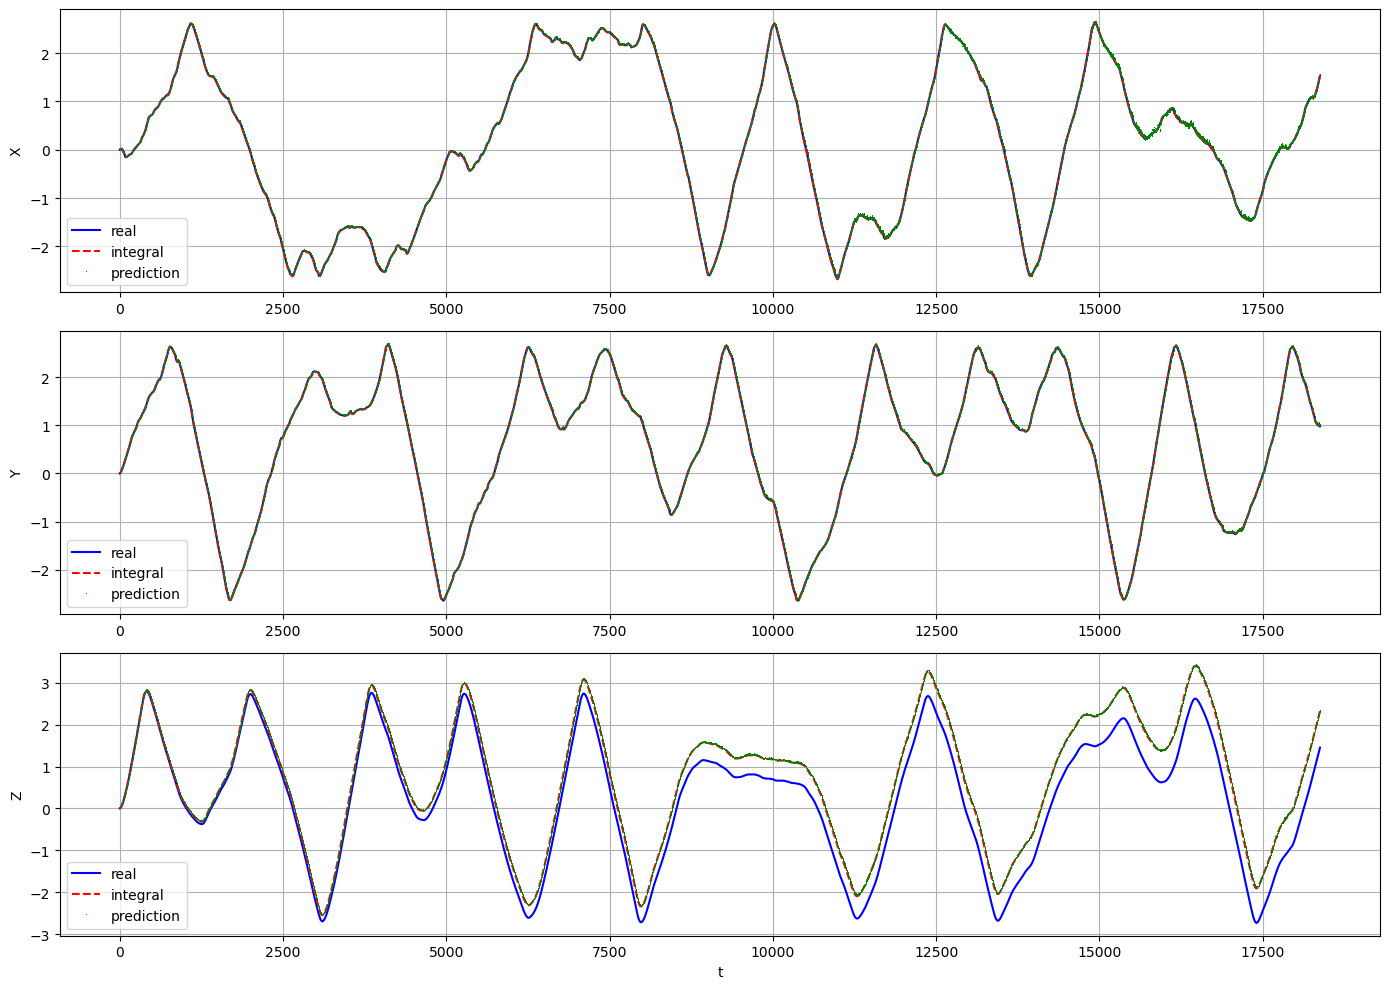

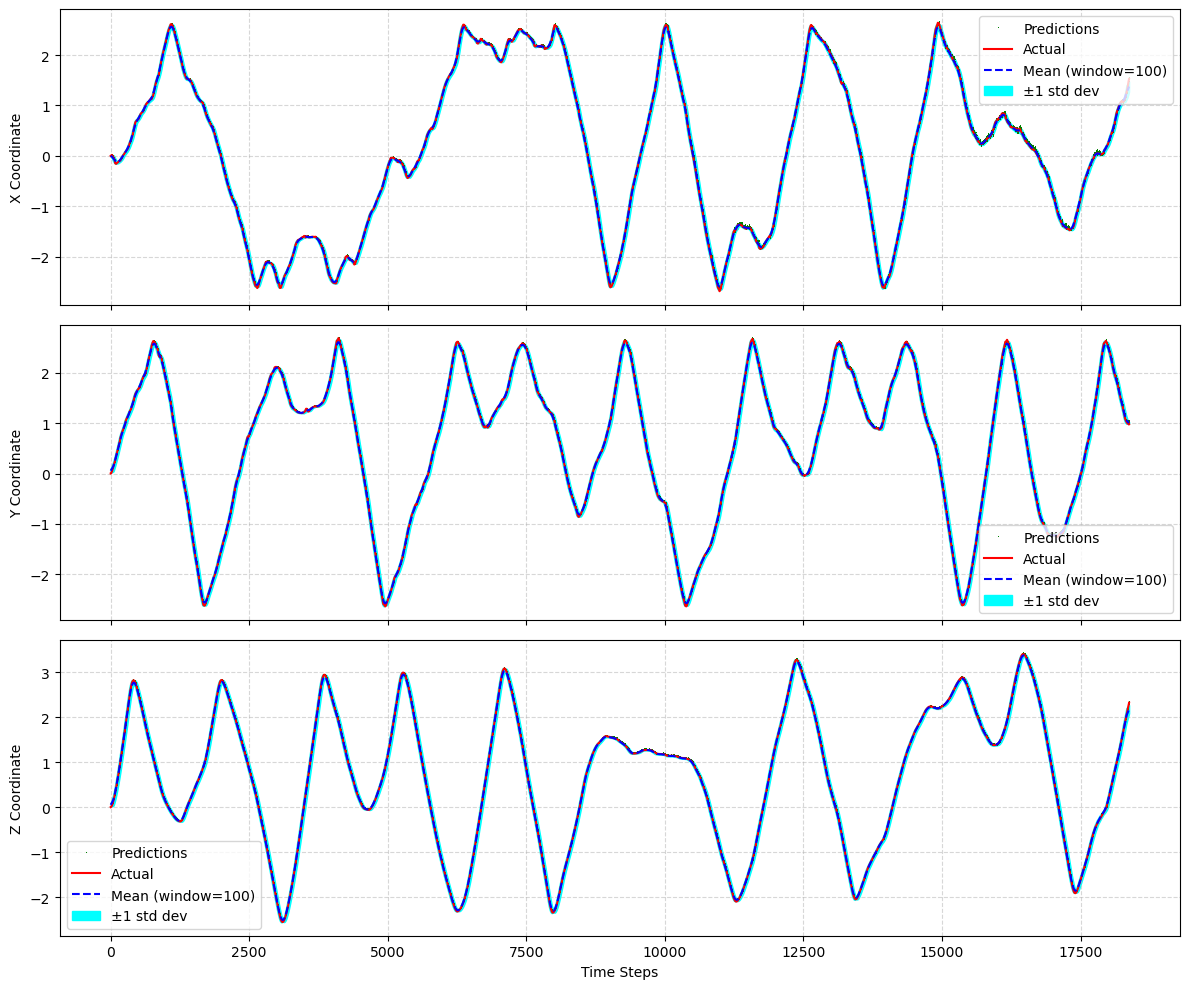

In [49]:
print(f'Simulation data\n Using gains:{gains}')
XYZoverTime(pos_r[start:], pos_i, pos_p)
plot_rolling_timeseries_stats(pos_i, pos_p, window_size=100)

In [50]:
pred_error = (pos_i - pos_p)**2
rolling_mean = np.zeros_like(pred_error[:,0])
rolling_std = np.zeros_like(pred_error[:,0])

window_size = 100
for j in range(len(pred_error)):
    # Determine the window boundaries
    start = max(0, j - window_size // 2)
    end = min(len(pred_error), j + window_size // 2)
    
    # Calculate local statistics
    window_data = pred_error[start:end]
    rolling_mean[j] = np.mean(window_data)
    rolling_std[j] = np.std(window_data)

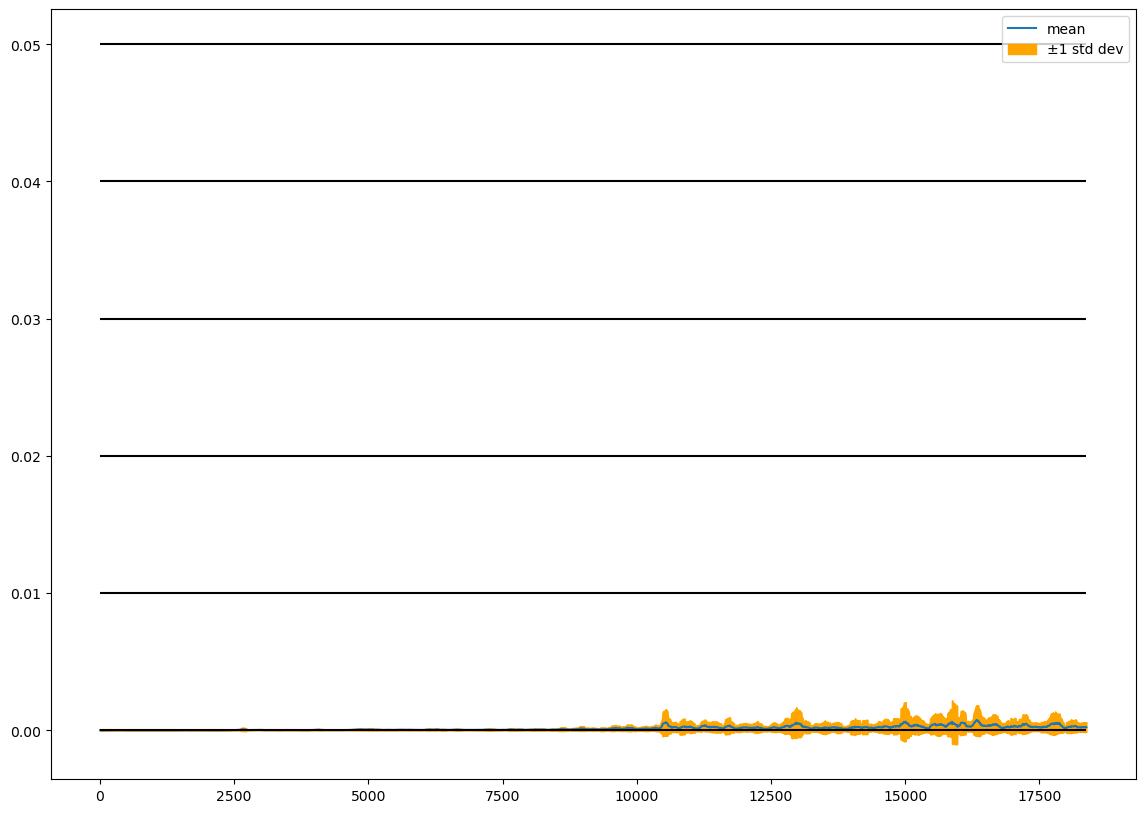

In [51]:
plt.plot(rolling_mean, label='mean')
plt.fill_between(range(len(pred_error)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='orange', label='±1 std dev')
#plt.plot(rolling_std, label='std')
plt.hlines([0, 0.01, 0.02, 0.03, 0.04, 0.05], 0, len(pred_error), color='k')
plt.legend()
plt.show()

# Neural Activity

Projection in ['X' 'Y']
Projection in ['Y' 'Z']


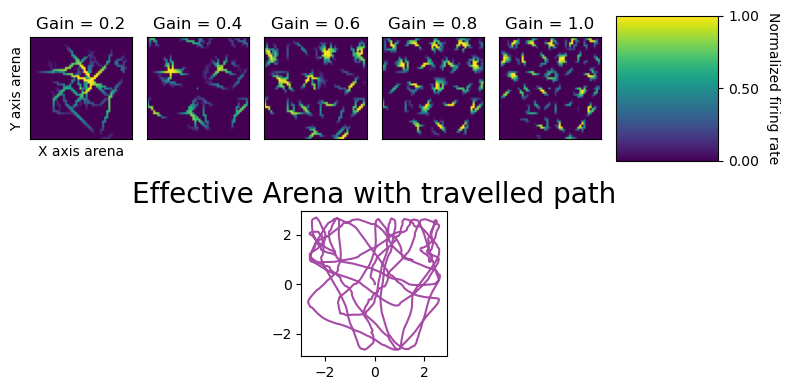

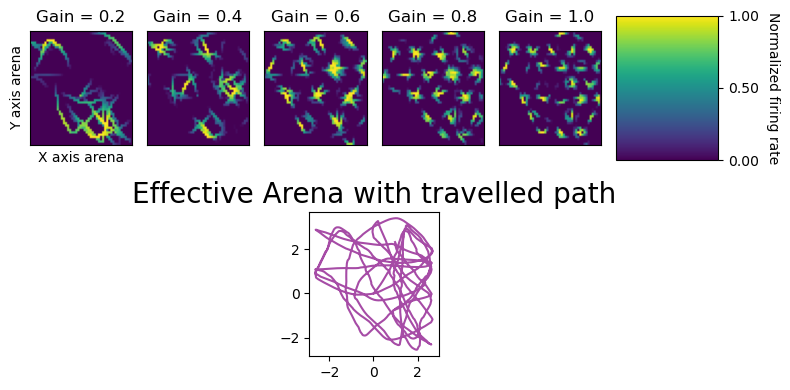

In [52]:
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)

# Reconstruct Data

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

def fit_linear_model(activity_array, pos, return_shuffled=False, alpha=1.0, cv_folds=10, seed=42):
    '''
    Predicts the location of the agent based on the activity level of the network

    :param activity_array: np.array featuring the time history of network activity. shape (ntime, (nmodules,) ngain, nneuron)
    :param pos: list of shape (ntime, ndim), position log of the agent
    :param return_shuffled: bool, default=False
    :param alpha: float, parameter used for the regression model
    :param cv_folds: int, amount of folds to divide the data into

    Returns:
        tuple: (X (np.array), y (np.array), y_pred (np.array), mse_mean (float), r2_mean (float)) OR
        tuple: (X (np.array), y (np.array), y_pred (np.array), mse_mean (float), mse_mean_shuffeled (float), r2_mean (float), r2_mean_shuffeled)
    '''
    np.random.seed(seed)

    X = np.array(activity_array).reshape(np.shape(activity_array)[0],-1)  # shape is (time, modules*gains*N)
    y = np.array(pos)  # shape is (time, 3)

    # Initialize the Ridge regression model with specified alpha
    model = Ridge(alpha=alpha)
    # model = LinearRegression()

    # Perform K-Fold cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=seed)

    # Cross-validation scores for MSE
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1) #n_jobs <- enables parallel processing
    #          parallel processing seems to malfunction with cleaning up temporary files, possible leading to memory leakage

    # Cross-validation scores for R2
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2', n_jobs=-1)
    # Crossval estimates
    y_pred = cross_val_predict(model, X, y, cv=kf)

    # Compute the average and standard deviation of MSE and R2 scores across folds
    mse_mean = round(np.mean(mse_scores), 5)
    mse_std = round(np.std(mse_scores), 5)
    r2_mean = round(np.mean(r2_scores), 5)
    r2_std = round(np.std(r2_scores), 5)

    if return_shuffled == False:
        return X, y, y_pred, mse_mean, r2_mean

    else:  # Fit linear model with shuffled labels
        y_shuffled = y.copy()
        np.random.shuffle(y_shuffled)  # Shuffle the labels
        mse_shuffled_scores = -cross_val_score(model, X, y_shuffled, cv=kf, scoring='neg_mean_squared_error') # Cross-validation scores for MSE with shuffled labels         
        r2_shuffled_scores = cross_val_score(model, X, y_shuffled, cv=kf, scoring='r2') # Cross-validation scores for R2 with shuffled labels

        # Compute the average and standard deviation of MSE and R2 scores for shuffled data
        mse_shuffled_mean = round(np.mean(mse_shuffled_scores), 5)
        mse_shuffled_std = round(np.std(mse_shuffled_scores), 5)
        r2_shuffled_mean = round(np.mean(r2_shuffled_scores), 5)
        r2_shuffled_std = round(np.std(r2_shuffled_scores), 5)

        return X, y, y_pred, mse_mean, mse_shuffled_mean, r2_mean, r2_shuffled_mean


In [18]:
X, y, y_pred, mse_mean, mse_shuffeled, r2_mean, r2_shuffeled = fit_linear_model(activity, pos_i, return_shuffled=True)

mse mean score = 0.22633 | the mean mean-squared-error between prediction and actuall position
mse shuffeled score = 2.478 | error when feature and output is randomly mixed
r2 mean score = 0.91 | score range[-inf, 1], a score close to 1 indicates that the model accounts closely for (in)regularities in data
r2 shuffeled score = -0.02515


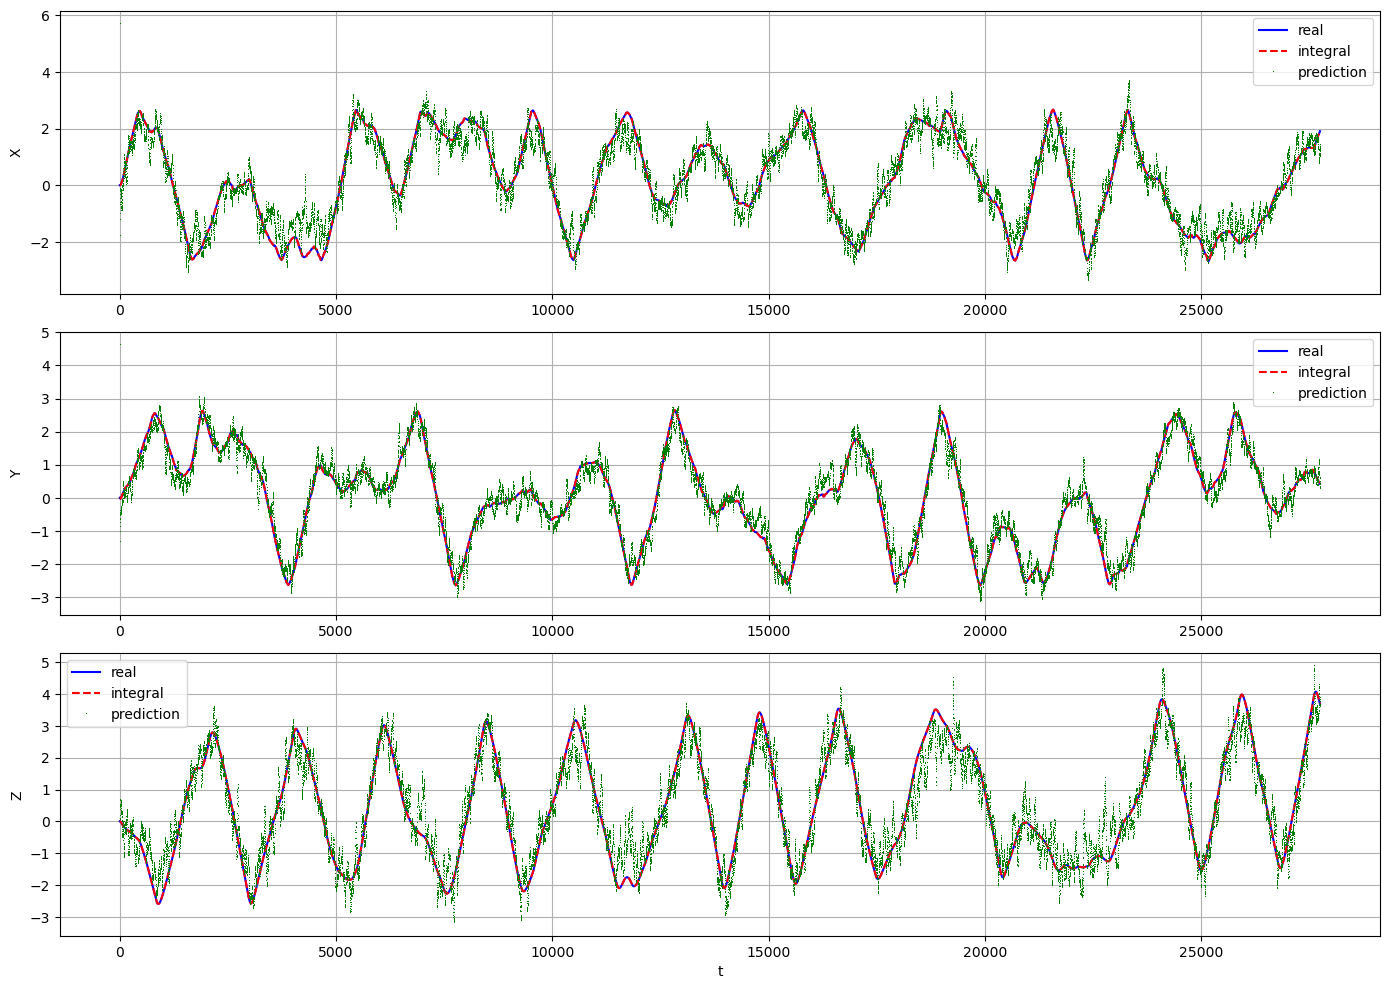

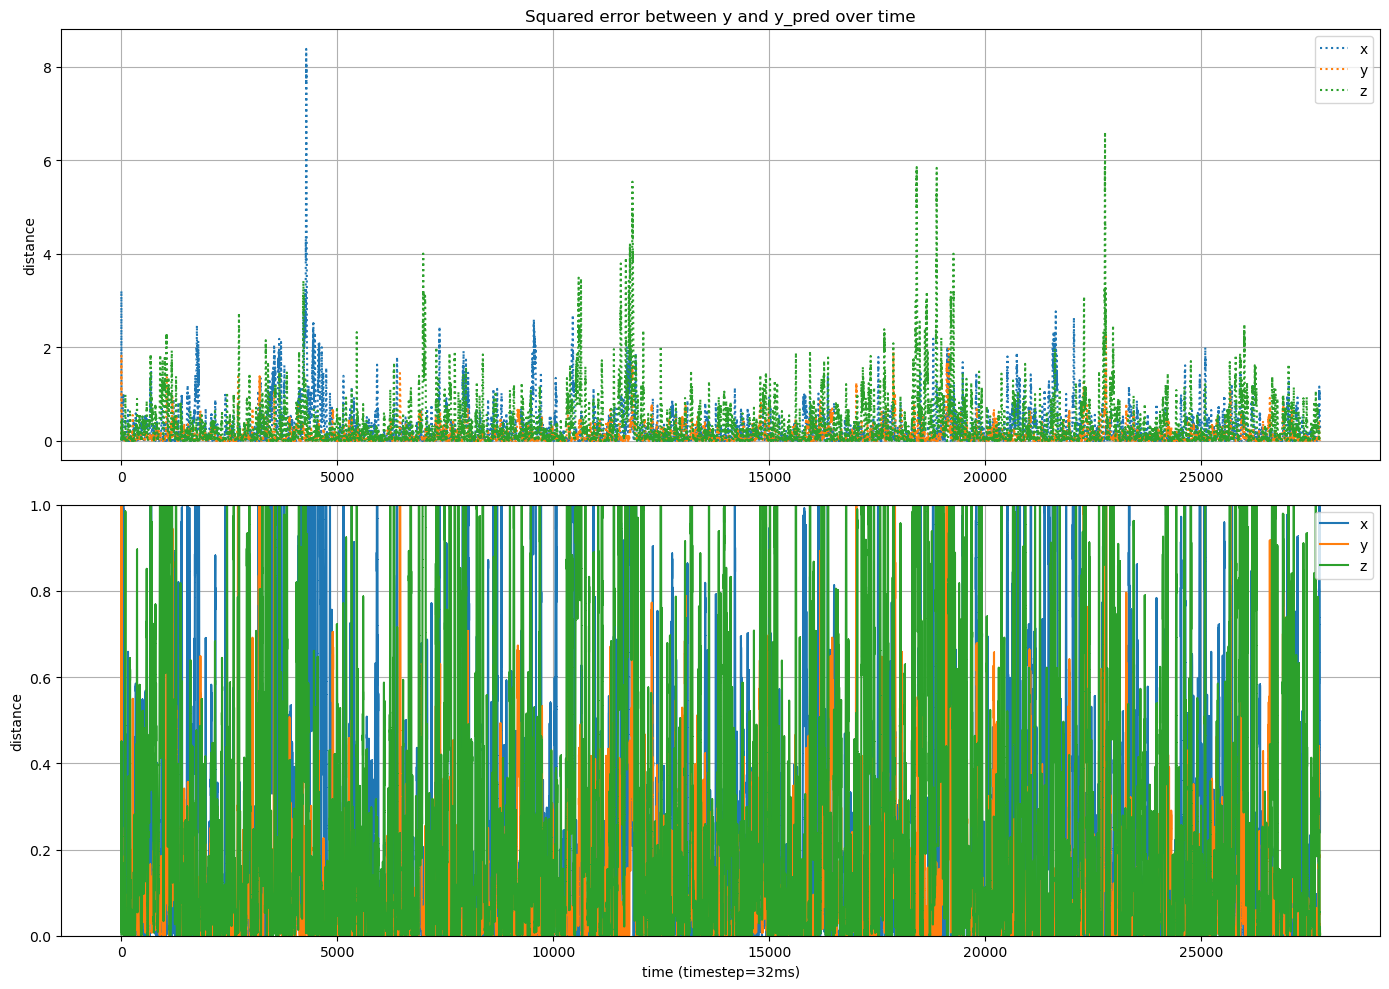

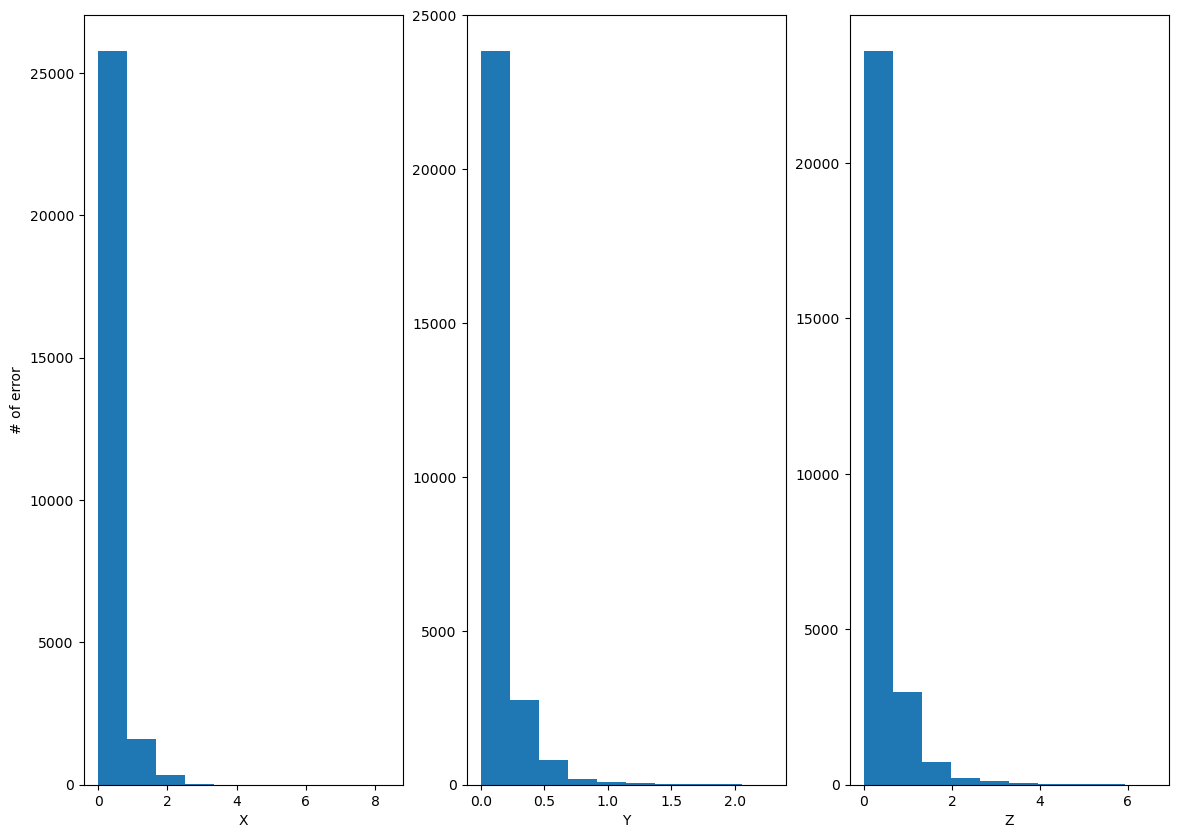

In [19]:
print(f'mse mean score = {mse_mean} | the mean mean-squared-error between prediction and actuall position')
print(f'mse shuffeled score = {mse_shuffeled} | error when feature and output is randomly mixed')
print(f'r2 mean score = {r2_mean} | score range[-inf, 1], a score close to 1 indicates that the model accounts closely for (in)regularities in data')
print(f'r2 shuffeled score = {r2_shuffeled}')
XYZoverTime(pos_i, y, y_pred)

error = (y-y_pred)**2
plt.subplot(2,1,1)
plt.title('Squared error between y and y_pred over time')
plt.plot(error[1:,0], ls='dotted', label='x')
plt.plot(error[1:,1], ls='dotted',label='y')
plt.plot(error[1:,2], ls='dotted',label='z')
plt.legend()
plt.grid()
plt.ylabel('distance')
plt.subplot(2,1,2)
plt.plot(error[1:,0], marker=',', label='x')
plt.plot(error[1:,1], marker=',', label='y')
plt.plot(error[1:,2], marker=',', label='z')
plt.legend()
plt.grid()
plt.ylabel('distance')
plt.ylim(0,1)
plt.xlabel('time (timestep=32ms)')
plt.tight_layout()
plt.show()

plt.subplot(1,3,1)
plt.ylabel('# of error')
plt.hist(error[1:,0])
plt.xlabel('X')
plt.subplot(1,3,2)
plt.hist(error[1:,1])
plt.xlabel('Y')
plt.subplot(1,3,3)
plt.hist(error[1:,2])
plt.xlabel('Z')
plt.show()

# Plot the results

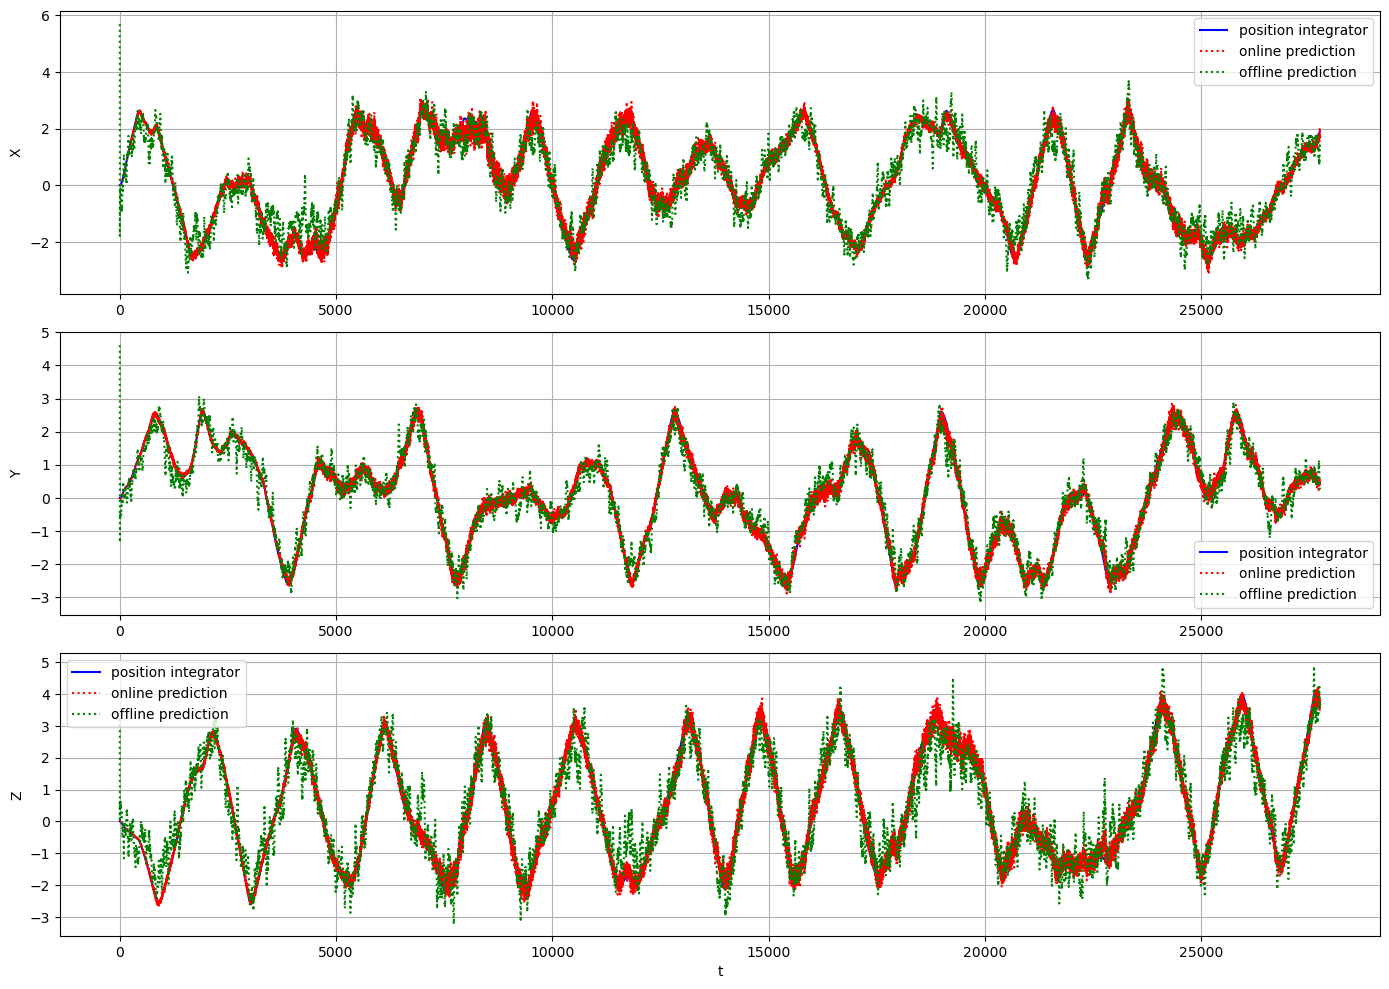

In [20]:
XYZoverTime(pos_i, pos_p, y_pred, [ 'position integrator', 'online prediction', 'offline prediction'], ['b-', 'r:', 'g:'])

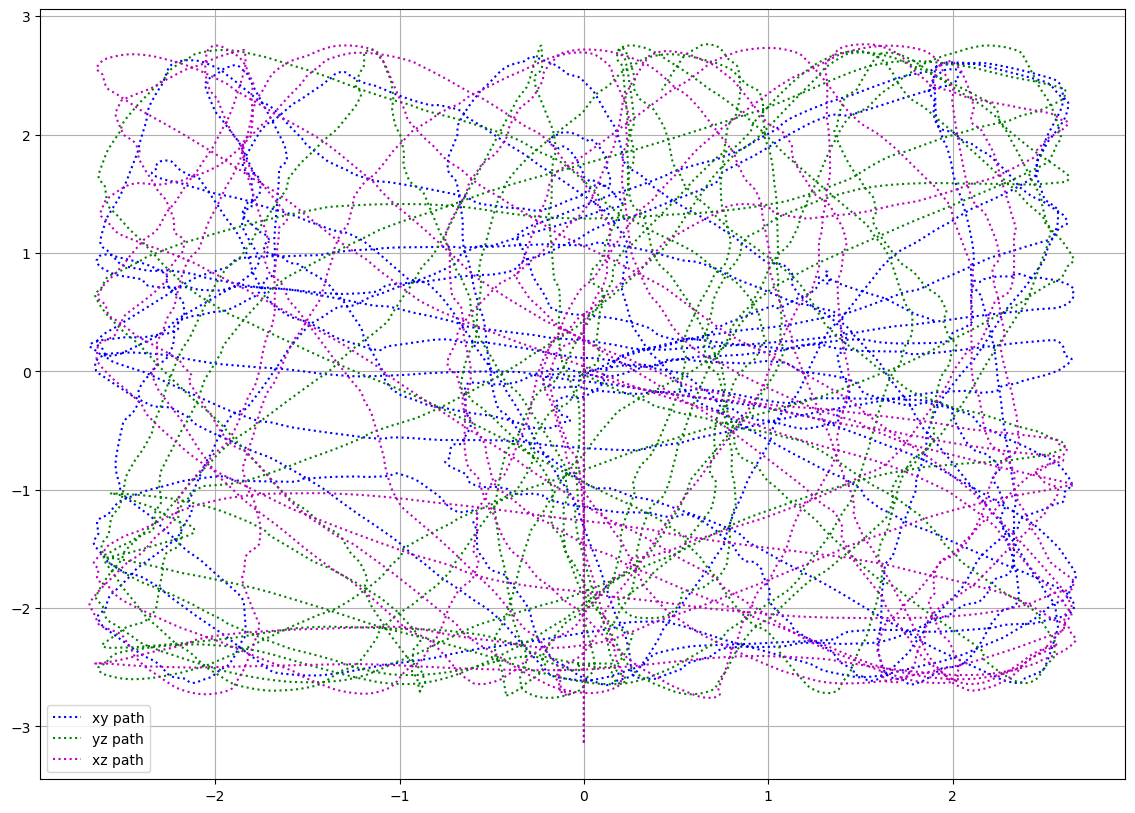

In [54]:
x, y, z = pos_r[:,0], pos_r[:,1], pos_r[:,2]
plt.plot(x, y, 'b:', label='xy path')
plt.plot(y, z, 'g:', label='yz path')
plt.plot(x, z, 'm:', label='xz path')
plt.grid()
plt.legend()
plt.show()

In [18]:
plot_3d_trajectory(pos_r, boundaries, ID=ID)

NameError: name 'plot_3d_trajectory' is not defined

In [ ]:
plot_prediction_path_3d(pos_r, pos_i, pos_r, np.mean(mse_ar), ID=ID)
prediction_path_projected(pos_i, pos_p, mse_ar, ID=ID)
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)

## Plot Trajectory 

In [ ]:
def plot_3d_trajectory(pos, boundaries, ID='null'):
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    start = 0
    stop = int(len(x))#/5)
    #stop = np.clip(stop, 10, 40000)

    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x[:stop], y[:stop], z[:stop], label='path')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    #plt.show()
    plt.savefig(f'Results\\ID {ID}\\3d_trajectory_spaceplot.png', format='png')
   # plt.close()

## Plot Prediction Path

In [ ]:
def plot_prediction_path_3d(path, path_in, path_pred, mse_mean, ID=0):
    stop = int(len(path)/5)
    stop = np.clip(stop, 10, 40000)
    # Unpack the actual and predicted coordinates
    x, y, z = path[:, 0], path[:, 1], path[:, 2]
    x_i, y_i, z_i = path_in[:, 0], path_in[:, 1], path_in[:, 2]
    x_pred, y_pred_val, z_pred = path_pred[:, 0], path_pred[:, 1], path_pred[:, 2]

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[:stop], y[:stop], z[:stop], label='Actual path', color='blue')
    ax.plot(x_i[:stop], y_i[:stop], z_i[:stop], 'g:', label='path integrator')
    ax.plot(x_pred[:stop], y_pred_val[:stop], z_pred[:stop], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    # End of simu
    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionF.png', format='png')
    #plt.show()
    #plt.close()

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[-stop:], y[-stop:], z[-stop:], label='Actual path', color='blue')
    ax.plot(x_i[-stop:], y_i[-stop:], z_i[-stop:], 'g:', label='path integrator')
    ax.plot(x_pred[-stop:], y_pred_val[-stop:], z_pred[-stop:], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionL.png', format='png')
    #plt.show()
    #plt.close()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path)/5)
    #stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

## Plot Neural Activity

## Produce Plots

In [ ]:
def generate_heatmap(x_min, x_max, y_min, y_max, num_bins, positions_array, network_activity, neuron=42):
    # Initialize an empty heatmap
    x_bins = np.linspace(x_min, x_max,num_bins)
    y_bins = np.linspace(y_min, y_max,num_bins)
    heatmap = np.zeros((num_bins, num_bins))

    # Iterate over positions and network_activity (Over time)
    for position, activity in zip(positions_array, network_activity):
        x_index = np.digitize(position[0], x_bins) - 1
        y_index = np.digitize(position[1], y_bins) - 1
        heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
        #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron
    return heatmap

In [ ]:
def activity_heatmap_projected(gains, prj_op, pos, ac, num_bins=50, neuron=42, ID=0, subID=None):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    for i, p in enumerate(pos2d):
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')
        
        x_min, y_min = np.min(positions_array, axis=0)
        x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(13, 8))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
        for a, alpha in enumerate(gains):
            heatmap_ax = fig.add_subplot(gs[0, a])
            heatmap_ax.set_aspect('equal')
    
            heatmap = generate_heatmap(x_min, x_max, y_min, y_max, num_bins, pos, act)

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID{ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID{ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    plt.show()
    plt.close()